In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# fix bug with plot
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

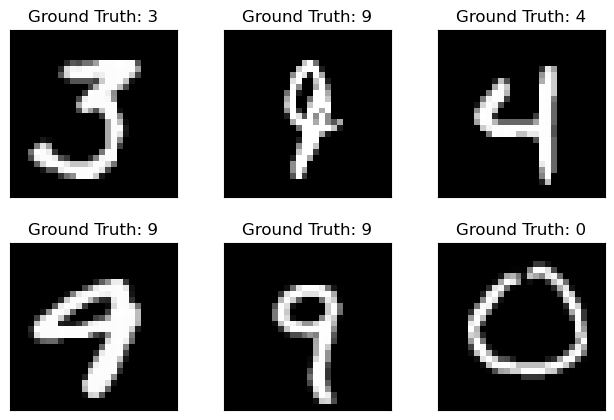

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
flatten_data = example_data.flatten(start_dim=1)
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = flatten_data.size(1), 100, 10

In [7]:
class Net(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(Net, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return F.log_softmax(y_pred, dim=1)

In [8]:
network = Net(D_in, H, D_out)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch, device='cpu'):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data.flatten(start_dim=1).to(device))
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [9]:
start_time = time.time()
for epoch in range(1, n_epochs + 1):
  train(epoch)
end_time = time.time()
cpu_time = end_time - start_time
print('CPU Time: ', cpu_time)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346312
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.061338
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.787498
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.563534
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.323617
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.157442
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.067432
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.896388
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.772468
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.583144
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.607685
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.453165
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.664993
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.581345
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.789183
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.552753
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.481114
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.365733
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.468975
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.505924
Train Epoch: 1 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

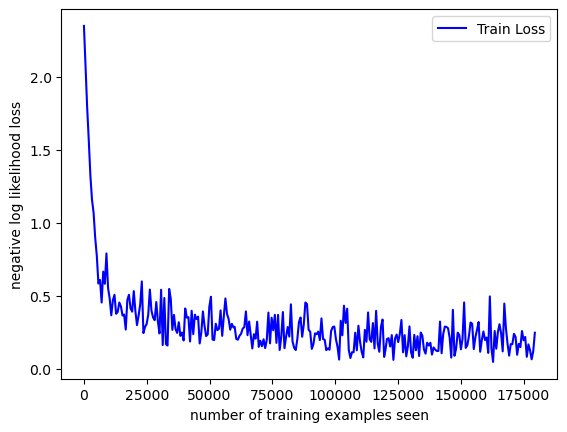

In [10]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data.flatten(start_dim=1))
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
test()


Test set: Avg. loss: 0.1700, Accuracy: 9488/10000 (95%)



In [12]:
device = 'cuda:0'
network = Net(D_in, H, D_out)
network = network.to(device)

start_time = time.time()
for epoch in range(1, n_epochs + 1):
  train(epoch, device)
end_time = time.time()
gpu_time = end_time - start_time
print('CPU time: ', cpu_time)
print('GPU time: ', gpu_time)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359850
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.324694
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.328172
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.284683
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.274698
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.288865
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.339605
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.311239
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.309225
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.296981
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.318682
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.377238
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.323323
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.285525
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.354936
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.308769
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.312096
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.288227
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.289169
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.306972
Train Epoch: 1 [12800/60000 (